Analysing Interactions with SHAP. Using the SHAP Python package to… | by Conor O'Sullivan | Towards Data Science
https://medium.com/p/8c4a2bc11c2a

https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=59135cf539aed9bbb8c0d68caaae1c0674c565b1&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f636f6e6f726f73756c6c792f6d656469756d2d61727469636c65732f353931333563663533396165643962626238633064363863616161653163303637346335363562312f7372632f736861705f637573746f6d2e6970796e62&logged_in=false&nwo=conorosully%2Fmedium-articles&path=src%2Fshap_custom.ipynb&platform=android&repository_id=255064249&repository_type=Repository&version=101

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
import seaborn as sns

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score,confusion_matrix

import shap
shap.initjs()

In [2]:
#import dataset
data = pd.read_csv("./data/abalone.data",
                  names=["sex","length","diameter","height","whole weight",
                         "shucked weight","viscera weight","shell weight","rings"])

y = data['rings']
X = data.drop('rings', axis=1)

#Create dummy variables
X['sex.M'] = [1 if s == 'M' else 0 for s in X['sex']]
X['sex.F'] = [1 if s == 'F' else 0 for s in X['sex']]
X['sex.I'] = [1 if s == 'I' else 0 for s in X['sex']]
X = X.drop('sex', axis=1)


print(len(data))
data.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
X.head()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,0,0
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,1,0,0
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,1,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,0,0
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,0,1


## Fit the model

In [5]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

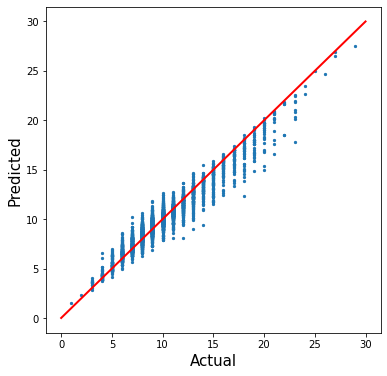

In [11]:
#Get predictions
y_pred = model.predict(X)

#Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,6))

plt.scatter(y,y_pred, s=5)
plt.plot([0, 30], [0, 30], color='r', linestyle='-', linewidth=2)

plt.ylabel('Predicted',size=15)
plt.xlabel('Actual',size=15)

#plt.savefig(path.format('regression_evaluation.png'),dpi=200,bbox_inches='tight')
plt.show()

## SHAP values

In [12]:
#Get shap values
explainer = shap.Explainer(model)

shap_values = explainer(X)
shap_interaction = explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [13]:
print(shap_values.shape)
print(shap_interaction.shape)

(4177, 10)
(4177, 10, 10)


In [14]:
# SHAP interaction values for first employee
pd.DataFrame(shap_interaction[0],index=X.columns,columns=X.columns)

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
length,-0.189966,-0.008239,0.159382,0.258326,0.107976,-0.079013,0.117757,0.008589,-0.002070,0.003937
diameter,-0.008239,0.001186,0.046868,0.078409,0.295737,0.039778,0.037995,-0.005197,-0.000691,0.015579
height,0.159382,0.046867,-0.209623,0.237510,-0.040167,-0.126381,0.232404,-0.003966,-0.000989,-0.007973
whole weight,0.258326,0.078409,0.237510,-0.826729,-0.096501,-0.068688,0.259911,-0.017585,-0.007307,-0.030761
shucked weight,0.107976,0.295737,-0.040167,-0.096501,1.682119,0.017617,-0.226582,0.011448,-0.025818,0.081309
viscera weight,-0.079013,0.039778,-0.126381,-0.068688,0.017617,0.193086,0.123005,0.007937,-0.006369,0.015798
shell weight,0.117758,0.037996,0.232404,0.259911,-0.226582,0.123005,-1.166347,-0.005187,0.025401,0.125194
sex.M,0.008589,-0.005197,-0.003966,-0.017585,0.011448,0.007937,-0.005187,0.007471,0.000000,0.000000
sex.F,-0.002069,-0.000691,-0.000989,-0.007307,-0.025818,-0.006368,0.025401,0.000000,-0.041518,0.000000
sex.I,0.003937,0.015579,-0.007973,-0.030761,0.081310,0.015798,0.125194,0.000000,0.000000,0.187849


In [15]:
#Get model predictions
y_pred = model.predict(X)

#Calculate mean prediction 
mean_pred = np.mean(y_pred)

#Sum of interaction values for first employee
sum_shap = np.sum(shap_interaction[0])

#Values below should be the same
print("Model prediction: {}".format(y_pred[0]))
print("Mean prediction + interaction values: {}".format(mean_pred+sum_shap))

Model prediction: 12.667574882507324
Mean prediction + interaction values: 12.667574882507324


**Question: differences between shap values and shap interaction values**

In [16]:
shap_values[0]

.values =
array([ 0.3766797 ,  0.50142586,  0.28706512, -0.21341547,  1.8071389 ,
        0.11677128, -0.47644863,  0.00351003, -0.05936054,  0.39093274],
      dtype=float32)

.base_values =
9.933275

.data =
array([0.455 , 0.365 , 0.095 , 0.514 , 0.2245, 0.101 , 0.15  , 1.    ,
       0.    , 0.    ])

### SHAP interaction plots

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text major ticklabel objects>)

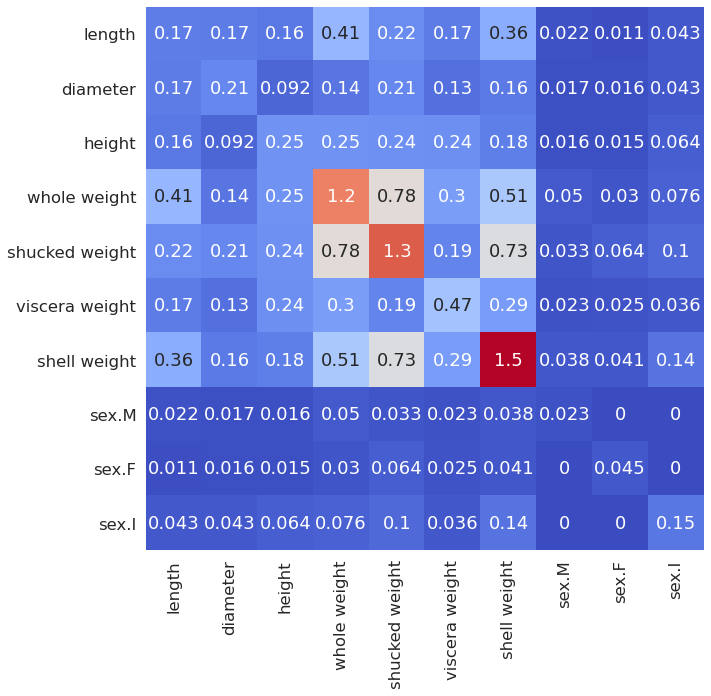

In [18]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap,index=X.columns,columns=X.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2,inplace=True)

# display 
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(df,cmap='coolwarm',annot=True,fmt='.2g',cbar=False)
plt.yticks(rotation=0) 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


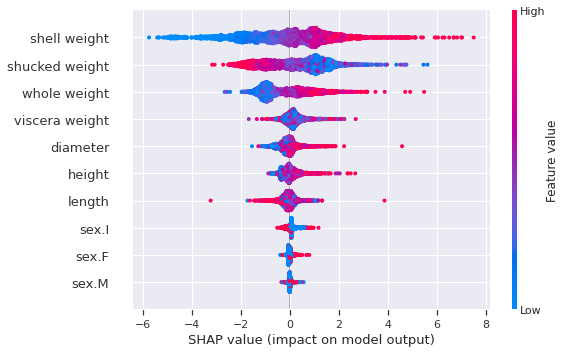

In [19]:
# Get SHAP values
shap_values = explainer(X)

#Display beeswarm plot
shap.plots.beeswarm(shap_values)

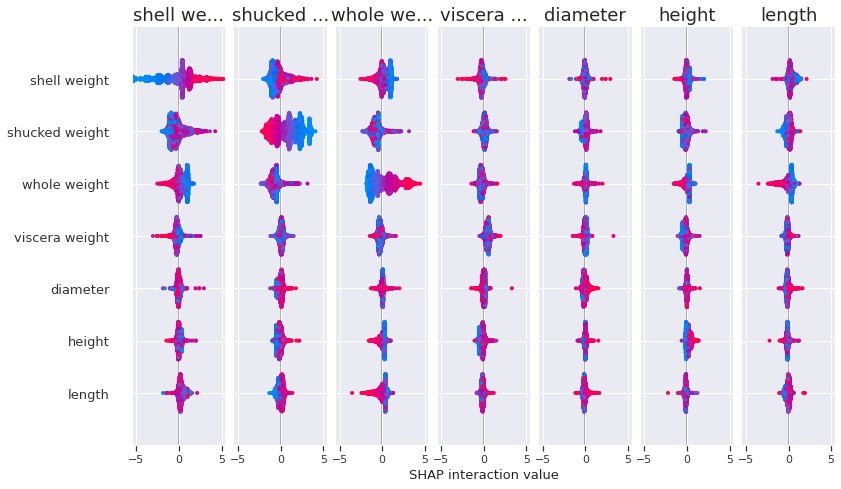

In [20]:
#Display summary plot
shap.summary_plot(shap_interaction, X)

## Dependence plots

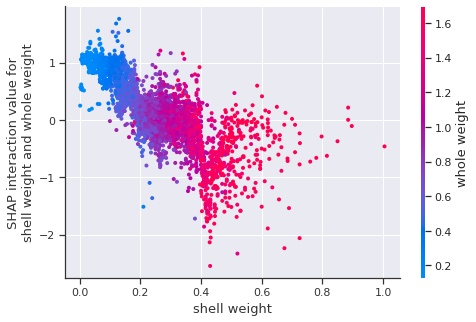

In [22]:
# Experience-degree depenence plot
shap.dependence_plot(
    ("shell weight", "whole weight"),
    shap_interaction, X,
    display_features=X)